## The Bias Variance Trade-off

### Packages Versions

In [1]:
import sys
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

print('The Python version is {}.\n'.format(sys.version))
print('The Numpy version is {}.\n'.format(np.__version__))
print('The Pandas version is {}.\n'.format(pd.__version__))
print('The Matplotlib version is {}.\n'.format(mpl.__version__))
print('The Scikit-Learn version is {}.\n'.format(sklearn.__version__))

The Python version is 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0].

The Numpy version is 1.19.1.

The Pandas version is 1.1.0.

The Matplotlib version is 3.3.3.

The Scikit-Learn version is 0.24.0.



### Logistic Regression Coefficients and Intercept Estimation

The **parameters** of a Logistic Regression model reflect the best approximation to the data. The process of finding this best approximation is called **estimation**. To estimate the best parameters the model uses a concept of **cost function**, which is a way of telling how far the model prediction are from perfectly describing the data.

In classification models there are different cost functions, being their particularities dependent on the model itself. Specifically in fitting logistic regression models, a typical cost function is the **log-loss** function (also called **cross entropy loss**):

>$ \text{LL} = \frac{1}{n}\sum_{i=1}^{n} - (y_{i}\log(p_{i}) + (1 - y_{i})\log(1 - p_{i}))$

Where $n$ is the training samples number, $y_{i}$ is the ture label (0 or 1) of the *i-th* sample, $p_{i}$ is the predicted probability $\frac{1}{1 + e^{-X}}$ that the *i-th* samples equals 1, and $\log$ is the natural logarithm. 

The summation notation over all the training samples and the division by $n$ serve to take the average of this cost function over all training samples.

Let's examine the log-loss function arguments. First, the natural logarithm distribution:

[0.01 0.02 0.03 0.04 0.05] ... [0.96 0.97 0.98 0.99]
[-4.60517019 -3.91202301] ... [-0.02020271 -0.01005034]


Text(0.5, 1.0, 'Natural Logarithm')

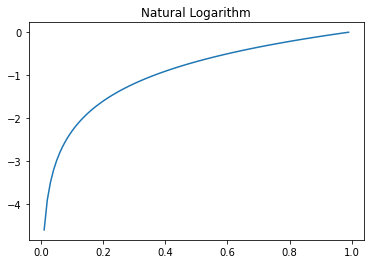

In [2]:
X_log = np.linspace(0.01, 0.99, 99)
y_log = np.log(X_log)

print(X_log[:5], '...', X_log[-4:])
print(y_log[:2], '...', y_log[-2:])

plt.plot(X_log, y_log)
plt.title('Natural Logarithm')

So, for a sample with positive class (in other words, with *y = 1*) the $(1 - y_{i})$ term equals zero and the cost function is reduced to:

> $ \text{LL} = \frac{1}{n}\sum_{i=1}^{n} - (\log(p_{i}))$

And the cost function is the negative of the natural logarithm of the predicted probability $p_{i}$. If this sample is correctly classified and the probability to be a positive class be close to 1, the $\log(p_{i})$  term will be close to 0. If, on the other hand, this sample is incorreclty predicted with a small $p_{i}$ value, the log loss will be high and therefore increase the overall sum.

For a sample with negative class (in other words, with *y = 0*) the $y_{i}\log(p_{i})$ term equals zeor and the cost function is reduced to:

> $ \text{LL} = \frac{1}{n}\sum_{i=1}^{n} - (\log(1 - p_{i}))$

And therefore, a similar behaviour occurs for the log loss value when the model predict a negative sample incorrectly. The $p_{i}$ will be high and the term $(1 - p_{i})$ will be low;

#### Gradient Descent

To find the best parameters, the a problem of **optimization** is set using the cost function. The **gradient descent** is the method used to make the **estimations**. It is an iterative algorithm that randomly attributes initial parameters values and iterates over the *error surface* - that is, the distribution of the **log loss** for different samples parameters - to find the least virtually cost. The gradient descent is calculated as:

> $x_{new} = x_{old} - f'(x_{old}) * \alpha$

Where $\alpha$ is the learning rate.

The new parameters values is based in the current guess $x_{old}$ and the derivative of it, $f'(x_{old})$, times a learning rate, being the learning rate a *step* to a *descent* - towards the local minimum - process.


So, for the Logistic Regression using the log loss cost function with just one feature, the first derivative result in (after some math that is omitted here):

> $\text{LL}' = \frac{1}{n} (y_{i} - p_{i}) * X_{j}$

Where $X_{j}$ is the is the input samples for the j-th input feature.


Let's simulate the process of finding the best parameters using synthetic data. The data will have only one feature, called **feat_1**, that is in fact a third degree polynomial:

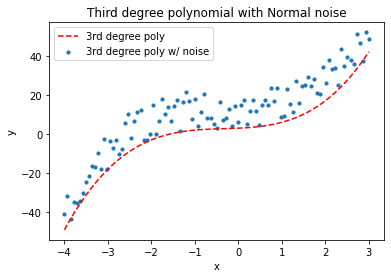

In [3]:
np.random.seed(seed=1)

X_poly = np.linspace(-4, 3, 101)

X_rand = np.random.uniform(0, 20, (101,))
Y_poly = X_poly ** 3 + X_poly ** 2 + X_poly + 3
Y_dist = X_poly ** 3 + X_poly ** 2 + X_poly + 3 + X_rand

y_true = X_poly >= 0

plt.plot(X_poly, Y_poly, 'r--')
plt.scatter(X_poly, Y_dist, s=10)
plt.ylabel('y')
plt.xlabel('x')
plt.title('Third degree polynomial with Normal noise')
plt.legend(['3rd degree poly', '3rd degree poly w/ noise'])

Let's create a DataFrame object:

In [4]:
df = pd.DataFrame({'feat_1': Y_dist, 'response': y_true})

And create train and tests sets:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df.feat_1, df.response, test_size=0.2, random_state=24)
print(X_train.shape)
print(X_test.shape)

(80,)
(21,)


Now, let's declare the logistic regression model with the training data:

In [6]:
model = LogisticRegression()
model.fit(np.array(X_train).reshape(-1, 1), np.array(y_train))

LogisticRegression()

Let's map the true values for the train data that will be used in the log loss functions and gradient functions:

In [7]:
y_train_true = np.array(y_train.map({True:1, False:0}))

Let's see the coefficients and the intercept paramenters of the model:

In [8]:
model.coef_, model.intercept_

(array([[0.22758664]]), array([-3.6139925]))

In [9]:
intercept_and_coefs = np.concatenate([model.intercept_.reshape(1,1), model.coef_], axis=1)
intercept_and_coefs

array([[-3.6139925 ,  0.22758664]])

Now, let's create some functions that will allow the parameter estimation manually:

In [10]:
def sigmoid(X):
    """
    Calculates the Sigmoid values of an array input.

    Arguments:
        X: Numpy array or DataFrame object
    Returns:
       Numpy array
    """
    return 1/(1 + np.exp(-X))

def linear_comb(X, Y):
    """
    Calculates the Linear Combination of two arrays (or pandas objects)

    Arguments:
        X, Y: Numpy arrays or DataFrame objects
    Returns:
        A Numpy array
    """
    assert X.shape[1] == Y.shape[0]
    return np.dot(X, Y)

def feature_array(X):
    """
    Make an array of features, with a column of 1s added, using horizontal stack

    Arguments:
        X: Numpy array or Dataframe object
    Returns:
        Numpy array
    """
    if len(X.shape) == 1:
        n = X.shape[0]
    else:
        n = X.shape[1]
    
    return np.hstack([np.ones((n, 1)),
                      np.array(X).reshape(-1,1)])

Let's create also a dataframe with the coefficients for each epoch. This will allow to track each iteration of the estimation process:

In [11]:
coefs = pd.DataFrame({'epochs': [0], 'theta_0': [0], 'theta_1': [0], 'cost': [np.inf]})
coefs

,epochs,theta_0,theta_1,cost
0,0,0,0,inf


Let's define the log loss function, the log loss gradient and the probability function:

In [12]:
def probabilities(X, Y):
    """
    Calculates the Logistic Regression positive class probabilities

    Arguments:
        X, Y: Numpy array
    Returns:
        Numpy array
    """
    return sigmoid(linear_comb(X, Y.T))

def log_loss(Y, T, X):
    """
    Estimates the log loss cost function.

    Arguments:
       Y, T, X: Numpy Array
    Returns:
       Numpy Array
    """
    n = len(Y)
    p = probabilities(X, T)

    total_cost = -(Y * np.log(p) + (1 - Y) * np.log(1 - p))

    return np.sum(total_cost) / n

def log_loss_gradient(Y, T, X):
    """
    Calculates the log loss gradient.

    Arguments:
        Y, T, X: Numpy Array
    Returns:
        Numpy Array
    """
    p = -(Y - probabilities(X, T))

    return (1/len(X)) * linear_comb(p.T, X)

For each epoch, we will save the values obtained in the estimation process in the coefs dataframe:

In [13]:
coefs = pd.DataFrame({'epochs': [0], 'theta_0': [0], 'theta_1': [0], 'cost': [np.nan]})
learning_rate = .05

for i in range(1, 1000):
    old = np.array(coefs[['theta_0', 'theta_1']].loc[i-1]).reshape(1,2)
    gradient = log_loss_gradient(y_train_true.reshape(-1, 1),
                                 old, 
                                 feature_array(X_train))
    new = old - (gradient * learning_rate)
    cost = log_loss(y_train_true.reshape(-1, 1),
                    new,
                    feature_array(X_train))

    coefs = coefs.append({'epochs': i,
                          'theta_0': new[0][0],
                          'theta_1': new[0][1],
                          'cost': cost}, ignore_index=True)

In [14]:
coefs

,epochs,theta_0,theta_1,cost
0,0.0,0.000000,0.000000,NaN
1,1.0,-0.005625,0.286111,1.121069
2,2.0,-0.022261,0.119162,0.623601
3,3.0,-0.036138,0.011686,0.630216
4,4.0,-0.042604,0.227193,0.917138
...,...,...,...,...
995,995.0,-2.709599,0.176171,0.312043
996,996.0,-2.710446,0.176218,0.312029
997,997.0,-2.711293,0.176265,0.312015
998,998.0,-2.712138,0.176312,0.312000


Lets plot the log loss cost function for this synthetic data:

Text(0.5, 1.0, 'Logistic Regression Training')

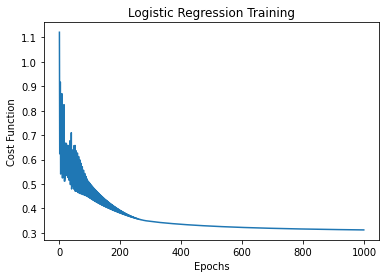

In [15]:
plt.plot(coefs.epochs, coefs.cost)
plt.ylabel('Cost Function')
plt.xlabel('Epochs')
plt.title('Logistic Regression Training')

It is possible to see from the above figure that the log loss function stoped at a minimum. In the beggining, the log loss values were somewhat erratic, but then it smoothed after 200 iterations.

Lets verify the log loss for the result parameters and compare with the LogisticRegression model:

In [16]:
mask = coefs.cost == coefs.cost.min()
coefs[mask]

,epochs,theta_0,theta_1,cost
999,999.0,-2.712982,0.176359,0.311986


In [17]:
print('Logistic Regression model intercept and coefficient: {}'.format(intercept_and_coefs))
print('Manual Regression model intercept and coefficient: {}'.format(coefs[['theta_0', 'theta_1']][mask].values))

Logistic Regression model intercept and coefficient: [[-3.6139925   0.22758664]]
Manual Regression model intercept and coefficient: [[-2.71298235  0.17635905]]


Not bat, pretty close. Let's compare the log loss cost function:

In [18]:
model_cost = log_loss(y_train_true.reshape(-1, 1),
                      intercept_and_coefs,
                      feature_array(X_train))

print('Logistic Regression model cost: {}'.format(model_cost))
print('Manual Regression model cost: {}'.format(coefs.cost[mask].values[0]))

Logistic Regression model cost: 0.304990771795166
Manual Regression model cost: 0.31198596238577425


As it is possible to see, the manual model cost for the final estimation parameters is pretty close to the scikit-learn model.

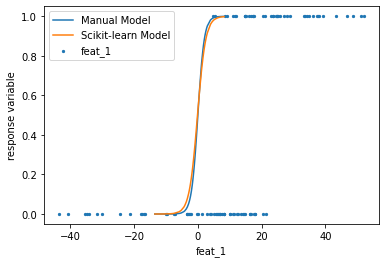

In [20]:
X_man = linear_comb(feature_array(df.feat_1.sort_values()), 
                    np.array(coefs[['theta_0', 'theta_1']].loc[999]).reshape(1,2).T)
Y_man = sigmoid(X_man)

X = linear_comb(feature_array(df.feat_1.sort_values()), 
                intercept_and_coefs.T)
Y = sigmoid(X)

plt.scatter(df.feat_1, df.response, s=5, c='y')
plt.plot(X, Y)
plt.plot(X, Y_man)
plt.ylabel('response variable')
plt.xlabel('feat_1')
plt.legend(['Manual Model', 'Scikit-learn Model', 'feat_1'])

### Assumptions of Logistic Regression

Since it is a classical statistical model, similar to F-test and Pearson correlation, logistic regression makes certain assumptions about the data. It is good to be aware of them, though in practice a model could be applied in less stricty situations.

**Features are linear in the log odds**

As Logistic Regression is a linear model (see details-of-logistic-regression-and-feature-exploration file), it is expected that the features describe a linear trend in the log odds. If not, as is the case with **pay_1** feature, the algorithm would not perform well.

**No Multicollinearity of Features**

Multicollinearity means that features are correlated with each other. The worst violation of this assumption is when features are perfectly correlated with each other (e.g. they are identical or multiplied by a scalar). In the study case, the **bill_amt_i** features are highly correlated between themselves, though they are not perfectly correlated. So, while these features may not contribute much independent information, let's keep them.

**The Independence of Observations**

This is a common assumption in classical statistical models, including linear regression. In this case study the samples are asssumed to be independent as represent accounts that are individual and unique (there are no accounts for the same person). So there is independence of observations in this respect.

**No outliers**

Outliers are observations where the value of the feature(s) or response are very far from most of the data, or are different in some other way. They are capable of affect linear models in general, because weights to much a parameter for both too high or too low. There were no outliers observed in this case study.

**Feature Numbers**

This is not an assumption, as it is more of a guidance on model building. Too many features can "confuse" the model. There is a common rule of thumb known as "rule of 10" which states that for every 10 occurrences of the rarest outcome class, 1 feature may be added to the model. For example, in a binary logistic regression problem with 100 samples, if the class balance is 20% positive, then are only 20 positive outcomes in total, and so only 2 features should be used in the model. There is also a "rule of 20" which is more stringent than the "rule of 10".


### Motivation for Regulatization

Regularization is a technique that contrains (**regularize**) or **shrinks** the model coefficients, balancing the model between complexity or flexibility on the feature relationships. Common terminology in machine-learning extends the regularization techniques into the following concepts:

- Overfitting
- Underfitting
- Bias-Variance trade-off

A model is said to have high **variance** when it captures very well the existing variability in the training set, showing high training scores. However, when such a model is then used to make predictions on unseen data, the performance is substantially lower compared to the training scores. 

Let's generate a quadratic data with random noise: